**For Figure 8 of the paper**

We want to plot the PDFs (or CDFs) of the inputs to the NNs once for Narval data and once for Qubicc data to see whether they align or not. I.e. whether the Narval-trained NN would have to generalize by a lot. 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Add path with my_classes to sys.path
sys.path.insert(0, '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/')
sys.path.insert(0, '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_cell_based_v2/source_code')

from my_classes import load_data
from for_preprocessing import Gamma_m
from LCL import lcl

## Plot joint distribution for temperature and pressure

In [2]:
# Loads the NARVAL data into the data_dict dictionary
# order_of_vars=['zg', 'fr_lake', 'fr_land', 'qv', 'qc', 'qi', 'temp', 'pres', 'rho', 'clc']
order_of_vars=['temp', 'pres']
data_dict_narval = load_data(source='narval', days='all', vert_interp=True, order_of_vars=order_of_vars)

temp
pres


In [3]:
# Loads the QUBICC data into the data_dict dictionary
# order_of_vars=['zg', 'fr_lake', 'fr_seaice', 'fr_land', 'hus', 'qclw_phy', 'cli', 'ta', 'pfull', 'rho', 'cl']
order_of_vars=['ta', 'pfull']
data_dict_qubicc = load_data(source='qubicc', days='all', vert_interp=True, order_of_vars=order_of_vars)

ta
pfull


175.09666895866394


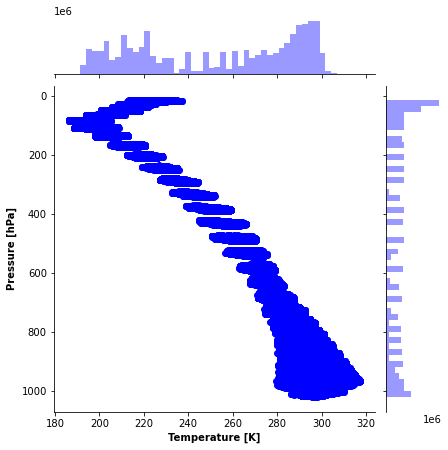

In [5]:
# kind = 'scatter' and kind = 'hex' take 0.2 seconds per timestep
# kind = 'reg' takes 6 seconds per timestep
# kind = 'kde' takes 25 seconds per timestep

t0 = time.time()
h = sns.jointplot(x=data_dict_narval['temp'], y=data_dict_narval['pres']/100, color='blue', kind='scatter')

# or set labels via the axes objects
h.ax_joint.set_xlabel('Temperature [K]', fontweight='bold')
h.ax_joint.set_ylabel('Pressure [hPa]', fontweight='bold')
plt.gca().invert_yaxis()
plt.savefig('Joint PDF of NARVAL pres and temp.png', bbox_inches="tight") # Careful about the size of the pdf
print(time.time() - t0)

1301.2246000766754


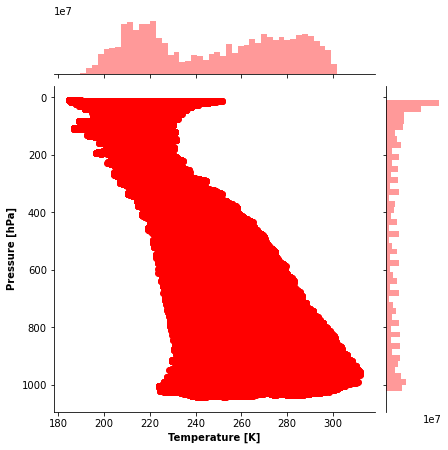

In [6]:
# kind = 'scatter' and kind = 'hex' take 0.2 seconds per timestep
# kind = 'reg' takes 6 seconds per timestep
# kind = 'kde' takes 25 seconds per timestep

t0 = time.time()
h = sns.jointplot(x=data_dict_qubicc['ta'], y=data_dict_qubicc['pfull']/100, color='red', kind='scatter')

# or set labels via the axes objects
h.ax_joint.set_xlabel('Temperature [K]', fontweight='bold')
h.ax_joint.set_ylabel('Pressure [hPa]', fontweight='bold')
plt.gca().invert_yaxis()
plt.savefig('Joint PDF of QUBICC pres and temp.png', bbox_inches="tight")
print(time.time() - t0)

1204.2828137874603


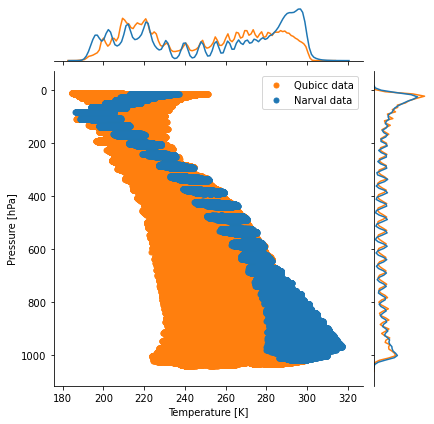

In [16]:
# Estimated upper limit on time it takes to run this cell: 3100s

tips = pd.DataFrame(columns=['Temperature [K]', 'Pressure [hPa]']) # For the variable names
# h = sns.JointGrid(x="Temperature [K]", y="Pressure [hPa]", data=data_dict_qubicc)
h = sns.JointGrid(x=tips["Temperature [K]"], y=tips["Pressure [hPa]"])

m = 721 # Maximum: 721
n = 1635 # Maximum: 1635

t0 = time.time()
sns.kdeplot(data_dict_qubicc['ta'][:m].reshape(-1), ax=h.ax_marg_x, legend=False, color='tab:orange')
sns.kdeplot(data_dict_qubicc['pfull'][:m].reshape(-1)/100, ax=h.ax_marg_y, vertical=True, legend=False, color='tab:orange')
h.ax_joint.plot(data_dict_qubicc['ta'][:m].reshape(-1), data_dict_qubicc['pfull'][:m].reshape(-1)/100, "o", ms=5, 
            color='tab:orange')

sns.kdeplot(data_dict_narval['temp'][:n].reshape(-1), ax=h.ax_marg_x, legend=False, color='tab:blue')
sns.kdeplot(data_dict_narval['pres'][:n].reshape(-1)/100, ax=h.ax_marg_y, vertical=True, legend=False, color='tab:blue')
h.ax_joint.plot(data_dict_narval['temp'][:n].reshape(-1), data_dict_narval['pres'][:n].reshape(-1)/100, "bo", ms=5,
               color='tab:blue')

h.ax_joint.legend(['Qubicc data', 'Narval data'], loc='upper right')

plt.gca().invert_yaxis()
plt.savefig('Joint_PDF_QUBICC_NARVAL_temperature_pressure.png', bbox_inches="tight")

print(time.time() - t0)

## Load Narval

In [ ]:
# Loads the NARVAL data into the data_dict dictionary
# order_of_vars=['zg', 'fr_lake', 'fr_land', 'qv', 'qc', 'qi', 'temp', 'pres', 'rho', 'clc']
order_of_vars=['zg', 'fr_lake', 'fr_land', 'qv', 'qc', 'qi', 'temp', 'pres', 'rho', 'clc']
data_dict = load_data(source='narval', days='all', vert_interp=True, order_of_vars=order_of_vars)

time_steps_narval = data_dict['qv'].shape[0]

#Reshaping into nd-arrays of equaling shapes
data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), time_steps_narval, axis=0)
data_dict['fr_lake'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 0), time_steps_narval, axis=0)
data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 0), time_steps_narval, axis=0)
data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 1), 31, axis=1)
data_dict['fr_lake'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 1), 31, axis=1)

# Temp minus near-surface temp
dT_narval = data_dict['temp'] - np.repeat(np.expand_dims(data_dict['temp'][:, -1, :], axis=1), 31, axis=1)
# Surface pressure
pres_sfc_narval = np.repeat(np.expand_dims(data_dict['pres'][:, -1, :], axis=1), 27, axis=1)

In [ ]:
# Computing EIS

## Relative humidity
T0 = 273.15
r_narval = 0.00263*data_dict['pres']*data_dict['qv']*np.exp((17.67*(data_dict['temp']-T0))/(data_dict['temp']-29.65))**(-1)

## Starting with potential temperature
p0 = np.repeat(np.expand_dims(data_dict['pres'][:, 30, :], axis=1), 31, axis=1)
pot_temp = data_dict['temp']*(p0/data_dict['pres'])**(0.286)

## Lower-tropospheric stability
# We have 700 hPa at roughly the 20th layer
ind_700 = np.argmin(np.abs(data_dict['pres'] - 70000), axis=1) # Matrix of shape time x hor
pot_temp_700 = np.array([[pot_temp[i, ind_700[i,j], j] for j in range(pot_temp.shape[2])] for i in range(pot_temp.shape[0])])

LTS_narval = pot_temp_700 - pot_temp[:, 30, :]

## The moist-adiabatic potential temperature gradient at 850hPa
ind_850 = np.argmin(np.abs(data_dict['pres'] - 85000), axis=1) #Indices corresponding to 850hPa
T_850 = np.array([[data_dict['temp'][i, ind_850[i,j], j] for j in range(pot_temp.shape[2])] for i in range(pot_temp.shape[0])])
p_850 = np.array([[data_dict['pres'][i, ind_850[i,j], j] for j in range(pot_temp.shape[2])] for i in range(pot_temp.shape[0])])

maptg = Gamma_m(T_850, p_850)

## Height at p=700hPa
z_700 = np.array([[data_dict['zg'][i, ind_700[i,j], j] for j in range(pot_temp.shape[2])] for i in range(pot_temp.shape[0])])

## LCL (due to Romps, 2017)
lcl_mat = np.zeros((data_dict['temp'].shape[0], data_dict['temp'].shape[2]))
for i in range(data_dict['temp'].shape[0]):
    for j in range(data_dict['temp'].shape[2]):
        lcl_mat[i,j] = lcl(p=data_dict['pres'][i, 30, j], T=data_dict['temp'][i, 30, j], rhl=r_narval[i,30,j])
        
EIS_narval = LTS_narval-maptg*(z_700-lcl_mat)

In [ ]:
EIS_narval = np.repeat(np.expand_dims(EIS_narval, 1), 27, axis=1)
LTS_narval = np.repeat(np.expand_dims(LTS_narval, 1), 27, axis=1)

In [ ]:
# Removing data above 21km
for key in data_dict.keys():
    data_dict[key] = data_dict[key][:,4:,:]
    print(data_dict[key].shape)
    
dT_narval = dT_narval[:,4:,:]
r_narval = r_narval[:,4:,:]

In [ ]:
#Reshaping into 1D-arrays and converting dict into a DataFrame-object (the following is based on Aurelien Geron)
for key in data_dict.keys():
    data_dict[key] = np.reshape(data_dict[key], -1) 
    
dT_narval = np.reshape(dT_narval, -1)
pres_sfc_narval = np.reshape(pres_sfc_narval, -1)
LTS_narval = np.reshape(LTS_narval, -1)
EIS_narval = np.reshape(EIS_narval, -1)

df_narval = pd.DataFrame.from_dict(data_dict)
df_narval.head()

## Load Qubicc

In [ ]:
# Loads the QUBICC data into the data_dict dictionary
# order_of_vars=['zg', 'fr_lake', 'fr_seaice', 'fr_land', 'hus', 'qclw_phy', 'cli', 'ta', 'pfull', 'rho', 'cl']
order_of_vars=['zg', 'fr_lake', 'fr_land', 'hus', 'qclw_phy', 'cli', 'ta', 'pfull', 'rho', 'cl']
data_dict = load_data(source='qubicc', days='all', vert_interp=True, order_of_vars=order_of_vars)

time_steps_qubicc = data_dict['hus'].shape[0]

#Reshaping into nd-arrays of equaling shapes
data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), time_steps_qubicc, axis=0)
data_dict['fr_lake'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 0), time_steps_qubicc, axis=0)
data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 0), time_steps_qubicc, axis=0)
# data_dict['fr_seaice'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 0), time_steps_qubicc, axis=0)
# data_dict['fr_seaice'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 1), 31, axis=1)
data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 1), 31, axis=1)
data_dict['fr_lake'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 1), 31, axis=1)
# Temp minus near-surface temp
dT_qubicc = data_dict['ta'] - np.repeat(np.expand_dims(data_dict['ta'][:, -1, :], axis=1), 31, axis=1)
# Surface pressure
pres_sfc_qubicc = np.repeat(np.expand_dims(data_dict['pfull'][:, -1, :], axis=1), 27, axis=1)

In [ ]:
# Computing EIS

## Relative humidity
T0 = 273.15
r_qubicc = 0.00263*data_dict['pfull']*data_dict['hus']*np.exp((17.67*(data_dict['ta']-T0))/(data_dict['ta']-29.65))**(-1)

## Starting with potential temperature
p0 = np.repeat(np.expand_dims(data_dict['pfull'][:, 30, :], axis=1), 31, axis=1)
pot_temp = data_dict['ta']*(p0/data_dict['pfull'])**(0.286)

## Lower-tropospheric stability
# We have 700 hPa at roughly the 20th layer
ind_700 = np.argmin(np.abs(data_dict['pfull'] - 70000), axis=1) # Matrix of shape time x hor
pot_temp_700 = np.array([[pot_temp[i, ind_700[i,j], j] for j in range(pot_temp.shape[2])] for i in range(pot_temp.shape[0])])

LTS_qubicc = pot_temp_700 - pot_temp[:, 30, :]

## The moist-adiabatic potential temperature gradient at 850hPa
ind_850 = np.argmin(np.abs(data_dict['pfull'] - 85000), axis=1) #Indices corresponding to 850hPa
T_850 = np.array([[data_dict['ta'][i, ind_850[i,j], j] for j in range(pot_temp.shape[2])] for i in range(pot_temp.shape[0])])
p_850 = np.array([[data_dict['pfull'][i, ind_850[i,j], j] for j in range(pot_temp.shape[2])] for i in range(pot_temp.shape[0])])

maptg = Gamma_m(T_850, p_850)

## Height at p=700hPa
z_700 = np.array([[data_dict['zg'][i, ind_700[i,j], j] for j in range(pot_temp.shape[2])] for i in range(pot_temp.shape[0])])

## LCL (due to Romps, 2017)
lcl_mat = np.zeros((data_dict['ta'].shape[0], data_dict['ta'].shape[2]))
for i in range(data_dict['ta'].shape[0]):
    for j in range(data_dict['ta'].shape[2]):
        lcl_mat[i,j] = lcl(p=data_dict['pfull'][i, 30, j], T=data_dict['ta'][i, 30, j], rhl=r_qubicc[i,30,j])
        
EIS_qubicc = LTS_qubicc-maptg*(z_700-lcl_mat)

In [ ]:
EIS_qubicc = np.repeat(np.expand_dims(EIS_qubicc, 1), 27, axis=1)
LTS_qubicc = np.repeat(np.expand_dims(LTS_qubicc, 1), 27, axis=1)

In [ ]:
# Removing data above 21km
for key in data_dict.keys():
    data_dict[key] = data_dict[key][:,4:,:]
    print(data_dict[key].shape)

dT_qubicc = dT_qubicc[:,4:,:]
r_qubicc = r_qubicc[:,4:,:]

In [ ]:
#Reshaping into 1D-arrays and converting dict into a DataFrame-object (the following is based on Aurelien Geron)
for key in data_dict.keys():
    data_dict[key] = np.reshape(data_dict[key], -1) 
    
dT_qubicc = np.reshape(dT_qubicc, -1)
pres_sfc_qubicc = np.reshape(pres_sfc_qubicc, -1)
LTS_qubicc = np.reshape(LTS_qubicc, -1)
EIS_qubicc = np.reshape(EIS_qubicc, -1)

df_qubicc = pd.DataFrame.from_dict(data_dict)
df_qubicc.head()

In [ ]:
def standardize(x, y):
    return (x-np.mean(y))/np.std(y)

def extrap_measure(x, y):
    '''
        The lower the extrap_measure (non-negative number), the less extrapolation is necessary from Qubicc to Narval.
        Here: x=Qubicc-Data, y=Narval-Data
    '''
    # Before the data is fed to the Neural network, it is standardized according to (a subset of the) NARVAL distribution.
    # So values that extend the standardized NARVAL range will be outside of the training range and require extrapolation.

    # The larger, the worse it is:
    max_gen = np.max(standardize(x,y)) - np.max(standardize(y,y))

    # The larger, the worse it is:
    min_gen = np.min(standardize(y,y)) - np.min(standardize(x,y))

    return (np.maximum(0, max_gen) + np.maximum(0, min_gen))

extrap_severity = {}

## Plotting

The integral over a given density plot always equals 1.
So the extent of the y-axis always depends on the range of the possible x-values.

One downside of density plots is that as they are a continuous (normalized) representation of the counts, it can extend to values (e.g. < 0) which do not appear in the data set.

Try https://towardsdatascience.com/sorry-but-sns-distplot-just-isnt-good-enough-this-is-though-ef2ddbf28078 to pack all plots into one!!

### Specific humidity

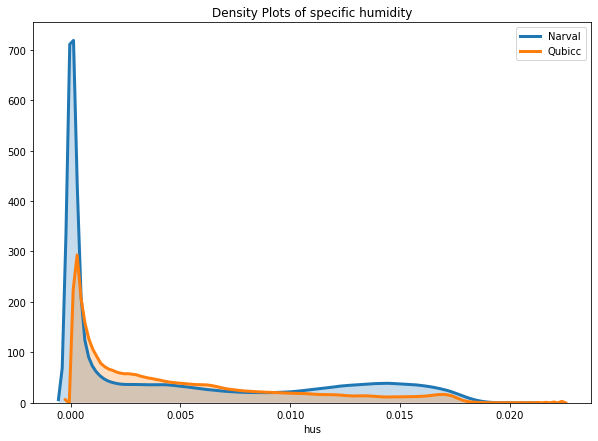

The values of specific humidity in Narval range between 0.0000 and 0.0207
The values of specific humidity in Qubicc range between 0.0000 and 0.0223


In [8]:
# Specific humidity
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of specific humidity')
sns.distplot(df_narval['qv'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['hus'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of specific humidity.pdf')
plt.show()

print('The values of specific humidity in Narval range between %.4f and %.4f'%
      (np.min(df_narval['qv']), np.max(df_narval['qv'])))
print('The values of specific humidity in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['hus']), np.max(df_qubicc['hus'])))

In [21]:
extrap_severity['qv'] = extrap_measure(df_qubicc['hus'], df_narval['qv'])
print('Extrapolation severity for specific humidity: %.3f'%extrap_severity['qv'])

Extrapolation severity for specific humidity: 0.272


### Cloud Water

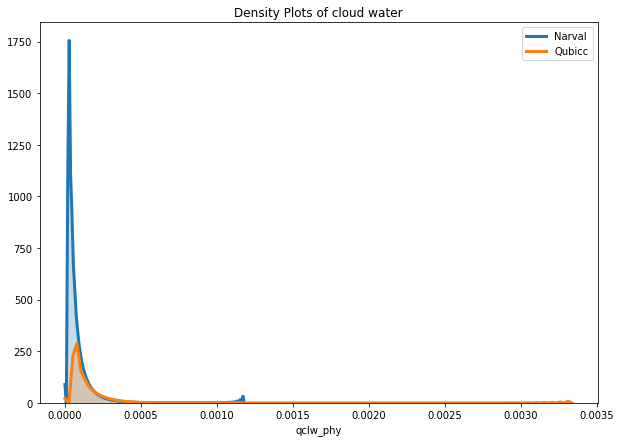

The values of cloud water in Narval range between 0.0000 and 0.0012
The values of cloud water in Qubicc range between 0.0000 and 0.0033


In [9]:
# Cloud Water
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of cloud water')
sns.distplot(df_narval['qc'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['qclw_phy'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of cloud water.pdf')
plt.show()

print('The values of cloud water in Narval range between %.4f and %.4f'%
      (np.min(df_narval['qc']), np.max(df_narval['qc'])))
print('The values of cloud water in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['qclw_phy']), np.max(df_qubicc['qclw_phy'])))

In [22]:
extrap_severity['qc'] = extrap_measure(df_qubicc['qclw_phy'], df_narval['qc'])
print('Extrapolation severity for cloud water: %.3f'%extrap_severity['qc'])

Extrapolation severity for cloud water: 77.455


### Cloud Ice

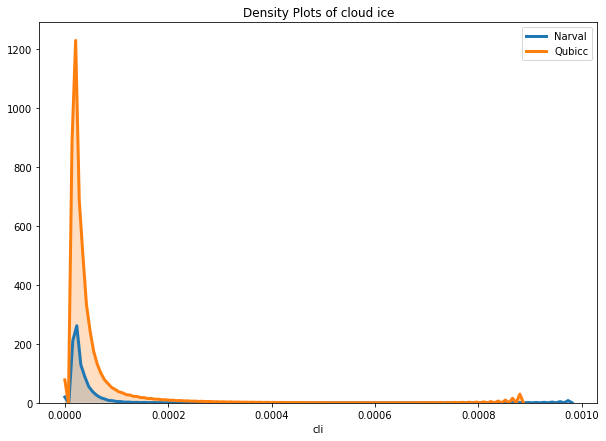

The values of cloud ice in Narval range between 0.0000 and 0.0010
The values of cloud ice in Qubicc range between 0.0000 and 0.0009


In [10]:
# Cloud Ice
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of cloud ice')
sns.distplot(df_narval['qi'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['cli'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of cloud ice.pdf')
plt.show()

print('The values of cloud ice in Narval range between %.4f and %.4f'%
      (np.min(df_narval['qi']), np.max(df_narval['qi'])))
print('The values of cloud ice in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['cli']), np.max(df_qubicc['cli'])))

In [23]:
extrap_severity['qi'] = extrap_measure(df_qubicc['cli'], df_narval['qi'])
print('Extrapolation severity for cloud ice: %.3f'%extrap_severity['qi'])

Extrapolation severity for cloud ice: 0.000


### Temperature

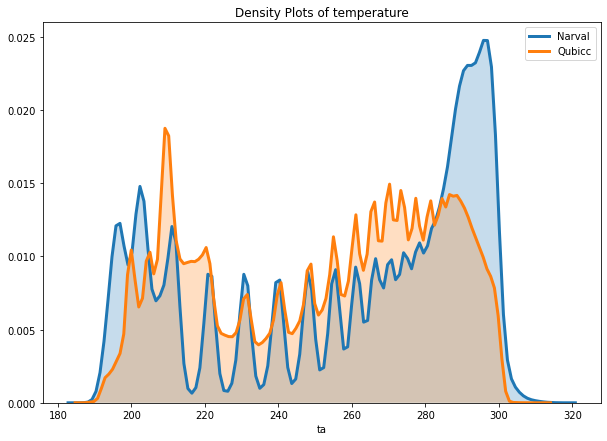

The values of temperature in Narval range between 186.1099 and 317.4575
The values of temperature in Qubicc range between 186.7064 and 312.0421


In [11]:
# Temperature
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of temperature')
sns.distplot(df_narval['temp'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['ta'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of temperature.pdf')
plt.show()

print('The values of temperature in Narval range between %.4f and %.4f'%
      (np.min(df_narval['temp']), np.max(df_narval['temp'])))
print('The values of temperature in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['ta']), np.max(df_qubicc['ta'])))

In [24]:
extrap_severity['temp'] = extrap_measure(df_qubicc['ta'], df_narval['temp'])
print('Extrapolation severity for temperature: %.3f'%extrap_severity['temp'])

Extrapolation severity for temperature: 0.000


### Air Pressure

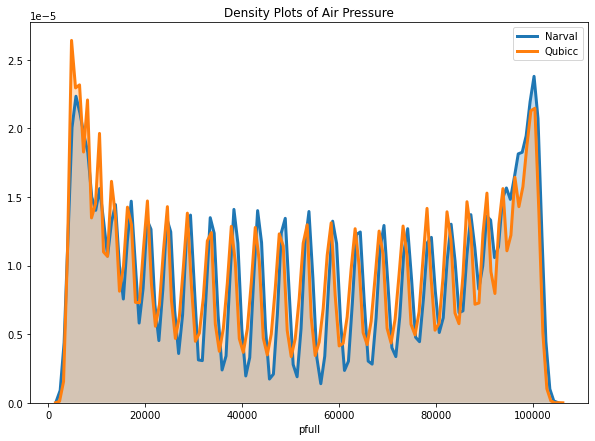

The values of Air Pressure in Narval range between 4753.9199 and 102045.4883
The values of Air Pressure in Qubicc range between 3636.3573 and 104078.1166


In [12]:
# Air Pressure
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of Air Pressure')
sns.distplot(df_narval['pres'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['pfull'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of Air Pressure.pdf')
plt.show()

print('The values of Air Pressure in Narval range between %.4f and %.4f'%
      (np.min(df_narval['pres']), np.max(df_narval['pres'])))
print('The values of Air Pressure in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['pfull']), np.max(df_qubicc['pfull'])))

In [25]:
extrap_severity['pres'] = extrap_measure(df_qubicc['pfull'], df_narval['pres'])
print('Extrapolation severity for pressure: %.3f'%extrap_severity['pres'])

Extrapolation severity for pressure: 0.096


### Air Density

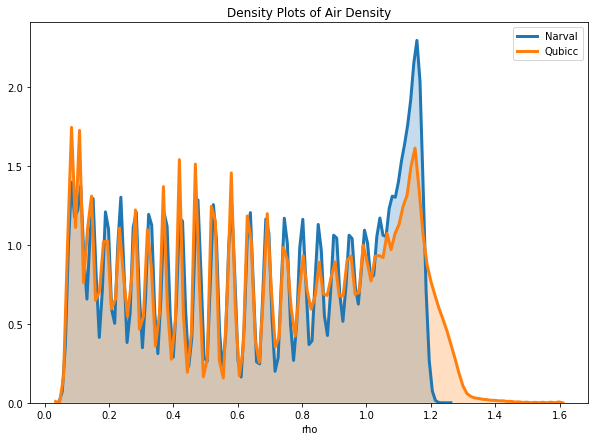

The values of Air Density in Narval range between 0.0786 and 1.2286
The values of Air Density in Qubicc range between 0.0577 and 1.5862


In [34]:
# Air Density
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of Air Density')
sns.distplot(df_narval['rho'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['rho'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of Air Density.pdf')
plt.show()

print('The values of Air Density in Narval range between %.4f and %.4f'%
      (np.min(df_narval['rho']), np.max(df_narval['rho'])))
print('The values of Air Density in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['rho']), np.max(df_qubicc['rho'])))

In [26]:
extrap_severity['rho'] = extrap_measure(df_qubicc['rho'], df_narval['rho'])
print('Extrapolation severity for air density: %.3f'%extrap_severity['rho'])

Extrapolation severity for air density: 1.052


### Cloud Cover

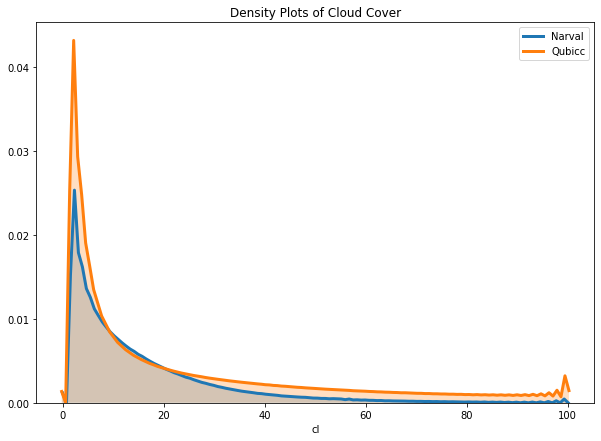

The values of Cloud Cover in Narval range between 0.0000 and 100.0000
The values of Cloud Cover in Qubicc range between 0.0000 and 100.0000


In [31]:
# Cloud Cover
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of Cloud Cover')
sns.distplot(df_narval['clc'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['cl']*100, hist = False, kde = True, 
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of Cloud Cover.pdf')
plt.show()

print('The values of Cloud Cover in Narval range between %.4f and %.4f'%
      (np.min(df_narval['clc']), np.max(df_narval['clc'])))
print('The values of Cloud Cover in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['cl'])*100, np.max(df_qubicc['cl'])*100))

### Fraction of lakes

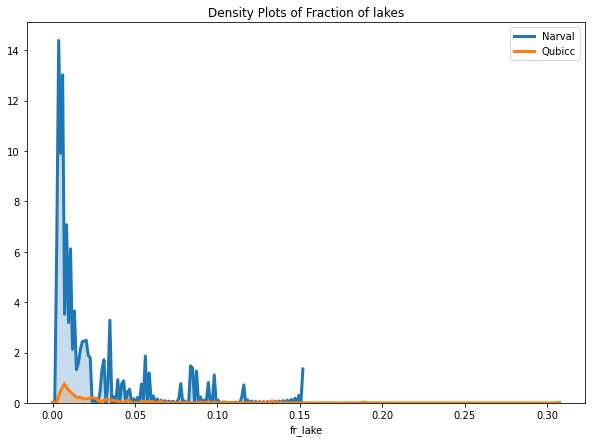

The values of Fraction of lakes in Narval range between 0.0000 and 0.1518
The values of Fraction of lakes in Qubicc range between 0.0000 and 0.3074


In [15]:
# Fraction of lakes
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of Fraction of lakes')
sns.distplot(df_narval['fr_lake'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['fr_lake'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of Fraction of lakes.pdf')
plt.show()

print('The values of Fraction of lakes in Narval range between %.4f and %.4f'%
      (np.min(df_narval['fr_lake']), np.max(df_narval['fr_lake'])))
print('The values of Fraction of lakes in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['fr_lake']), np.max(df_qubicc['fr_lake'])))

In [27]:
extrap_severity['fr_lake'] = extrap_measure(df_qubicc['fr_lake'], df_narval['fr_lake'])
print('Extrapolation severity for fraction of lakes: %.3f'%extrap_severity['fr_lake'])

Extrapolation severity for fraction of lakes: 14.116


### Fraction of land

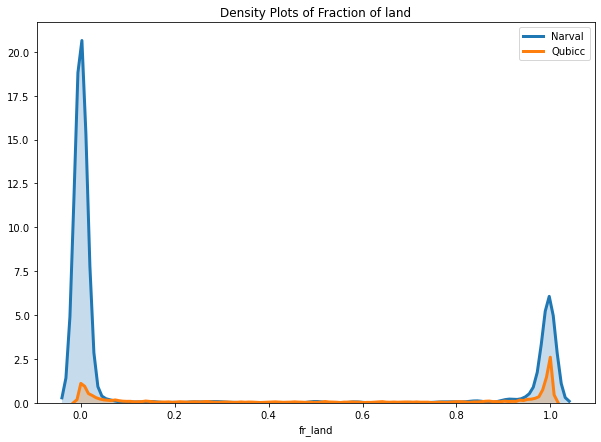

The values of Fraction of land in Narval range between 0.0000 and 1.0000
The values of Fraction of land in Qubicc range between 0.0000 and 1.0000


In [56]:
# Fraction of land
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of Fraction of land')
sns.distplot(df_narval['fr_land'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(df_qubicc['fr_land'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of Fraction of land.pdf')
plt.show()

print('The values of Fraction of land in Narval range between %.4f and %.4f'%
      (np.min(df_narval['fr_land']), np.max(df_narval['fr_land'])))
print('The values of Fraction of land in Qubicc range between %.4f and %.4f'%
      (np.min(df_qubicc['fr_land']), np.max(df_qubicc['fr_land'])))

In [28]:
extrap_severity['fr_land'] = extrap_measure(df_qubicc['fr_land'], df_narval['fr_land'])
print('Extrapolation severity for fraction of land: %.3f'%extrap_severity['fr_land'])

Extrapolation severity for fraction of land: 0.000


<!-- ### Fraction of Sea Ice -->

In [17]:
# # Fraction of Sea Ice
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, title='Density Plots of Fraction of Sea Ice')
# sns.distplot(df_narval['fr_seaice'], hist = False, kde = True,
#                  kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
# sns.distplot(df_qubicc['fr_seaice'], hist = False, kde = True,
#                  kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
# plt.savefig('Density Plots of Fraction of Sea Ice.pdf')
# plt.show()

# print('The values of Fraction of Sea Ice in Narval range between %.4f and %.4f'%
#       (np.min(df_narval['fr_seaice']), np.max(df_narval['fr_seaice'])))
# print('The values of Fraction of Sea Ice in Qubicc range between %.4f and %.4f'%
#       (np.min(df_qubicc['fr_seaice']), np.max(df_qubicc['fr_seaice'])))

### Relative humidity

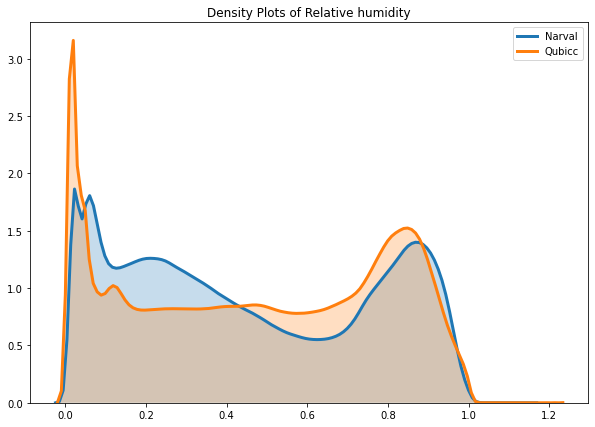

The values of Relative humidity in Narval range between 0.0049 and 1.1400
The values of Relative humidity in Qubicc range between 0.0008 and 1.2134


In [18]:
# Specific humidity to Relative humidity
T0 = 273.15
r_narval = 0.00263*df_narval['pres']*df_narval['qv']*np.exp((17.67*(df_narval['temp']-T0))/(df_narval['temp']-29.65))**(-1)
r_qubicc = 0.00263*df_qubicc['pfull']*df_qubicc['hus']*np.exp((17.67*(df_qubicc['ta']-T0))/(df_qubicc['ta']-29.65))**(-1)

# Plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of Relative humidity')
sns.distplot(r_narval, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(r_qubicc, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of Relative humidity.pdf')
plt.show()

print('The values of Relative humidity in Narval range between %.4f and %.4f'%
      (np.min(r_narval), np.max(r_narval)))
print('The values of Relative humidity in Qubicc range between %.4f and %.4f'%
      (np.min(r_qubicc), np.max(r_qubicc)))

In [29]:
extrap_severity['r'] = extrap_measure(r_qubicc, r_narval)
print('Extrapolation severity for relative humidity: %.3f'%extrap_severity['r'])

Extrapolation severity for relative humidity: 0.254


### Temperature minus near-surface temperature

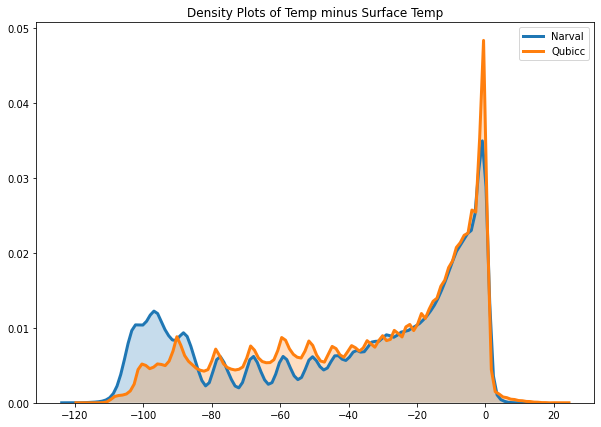

The values of Temp minus Surface Temp in Narval range between -120.4922 and 9.7553
The values of Temp minus Surface Temp in Qubicc range between -117.6538 and 22.3790


In [57]:
# Plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of Temp minus Surface Temp')
sns.distplot(dT_narval, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(dT_qubicc, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of Temp minus Surface Temp.pdf')
plt.show()

print('The values of Temp minus Surface Temp in Narval range between %.4f and %.4f'%
      (np.min(dT_narval), np.max(dT_narval)))
print('The values of Temp minus Surface Temp in Qubicc range between %.4f and %.4f'%
      (np.min(dT_qubicc), np.max(dT_qubicc)))

In [30]:
extrap_severity['dT'] = extrap_measure(dT_qubicc, dT_narval)
print('Extrapolation severity for Temp minus Surface Temp: %.3f'%extrap_severity['dT'])

Extrapolation severity for Temp minus Surface Temp: 0.352


### Surface pressure

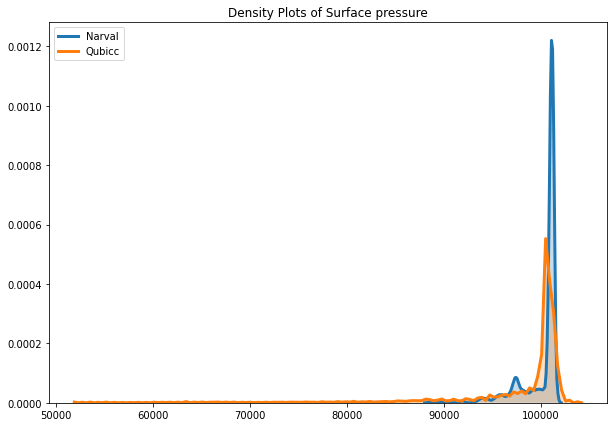

The values of Surface pressure in Narval range between 88052.5781 and 102045.4883
The values of Surface pressure in Qubicc range between 51983.4961 and 104078.1166


In [58]:
# Plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of Surface pressure')
sns.distplot(pres_sfc_narval, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(pres_sfc_qubicc, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of Surface pressure.pdf')
plt.show()

print('The values of Surface pressure in Narval range between %.4f and %.4f'%
      (np.min(pres_sfc_narval), np.max(pres_sfc_narval)))
print('The values of Surface pressure in Qubicc range between %.4f and %.4f'%
      (np.min(pres_sfc_qubicc), np.max(pres_sfc_qubicc)))

In [31]:
extrap_severity['pres_sfc'] = extrap_measure(pres_sfc_qubicc, pres_sfc_narval)
print('Extrapolation severity for Surface Pressure: %.3f'%extrap_severity['pres_sfc'])

Extrapolation severity for Surface Pressure: 20.111


### LTS

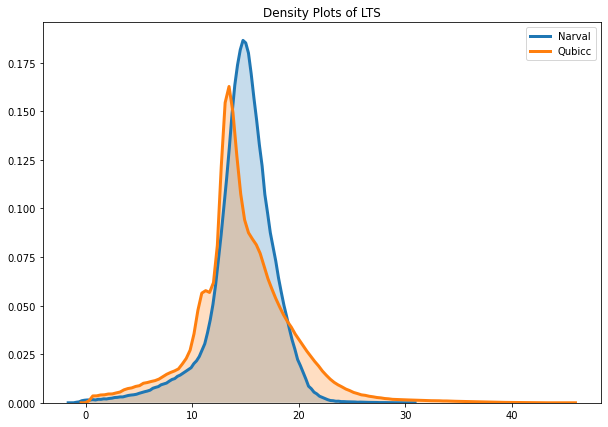

The values of LTS in Narval range between -1.4114 and 30.6990
The values of LTS in Qubicc range between -0.1896 and 45.7349


In [59]:
# Plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of LTS')
sns.distplot(LTS_narval, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(LTS_qubicc, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of LTS.pdf')
plt.show()

print('The values of LTS in Narval range between %.4f and %.4f'%
      (np.min(LTS_narval), np.max(LTS_narval)))
print('The values of LTS in Qubicc range between %.4f and %.4f'%
      (np.min(LTS_qubicc), np.max(LTS_qubicc)))

In [32]:
extrap_severity['LTS'] = extrap_measure(LTS_qubicc, LTS_narval)
print('Extrapolation severity for LTS: %.3f'%extrap_severity['LTS'])

Extrapolation severity for LTS: 4.883


### EIS

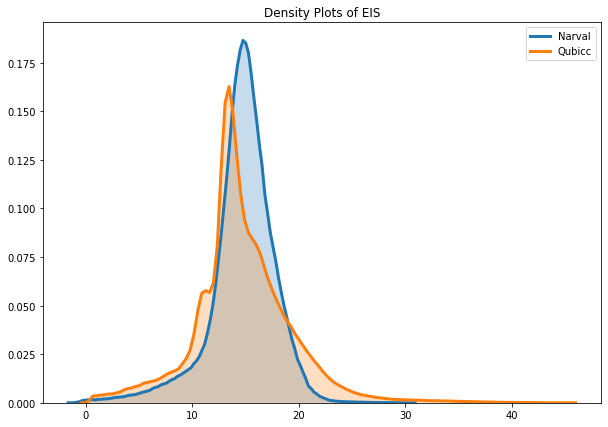

The values of EIS in Narval range between -9.1273 and 25.5523
The values of EIS in Qubicc range between -20.8173 and 42.2133


In [60]:
# Plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, title='Density Plots of EIS')
sns.distplot(LTS_narval, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Narval')
sns.distplot(LTS_qubicc, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Qubicc')
plt.savefig('Density Plots of EIS.pdf')
plt.show()

print('The values of EIS in Narval range between %.4f and %.4f'%
      (np.min(EIS_narval), np.max(EIS_narval)))
print('The values of EIS in Qubicc range between %.4f and %.4f'%
      (np.min(EIS_qubicc), np.max(EIS_qubicc)))

In [33]:
extrap_severity['EIS'] = extrap_measure(EIS_qubicc, EIS_narval)
print('Extrapolation severity for EIS: %.3f'%extrap_severity['EIS'])

Extrapolation severity for EIS: 8.072


## Feature Extrapolation Ranking

In [45]:
print('Smaller is better')
for elem in sorted(extrap_severity.items(), key=lambda x:x[1]):
    print("%10s: %.3f"%elem)

Smaller is better
        qi: 0.000
      temp: 0.000
   fr_land: 0.000
      pres: 0.096
         r: 0.254
        qv: 0.272
        dT: 0.352
       rho: 1.052
       LTS: 4.883
       EIS: 8.072
   fr_lake: 14.116
  pres_sfc: 20.111
        qc: 77.455
